In [1]:
import numpy as np
import math
import random
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt 
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
from matplotlib.pyplot import figure
from mpl_toolkits import mplot3d
from matplotlib.backends.backend_pdf import PdfPages
import csv
import fractions
import scipy

# Generate $N_{pixel}$ coordinates over the sky

In [ ]:
nside = hp.pixelfunc.order2nside(5)
print(nside)
npix = hp.nside2npix(nside)
print("Number of pixels:")
print(npix)
m =  np.arange(npix)
print("Map:")
print(m)
print("Plot map")
hp.mollview(m)
print("Pixel theta (colatitude) and phi (longitude) in radians:")
i_pix = np.arange(npix)
theta, phi = hp.pix2ang(nside, i_pix, nest=False, lonlat=False  )

# Psudo particle trajectory 

In [ ]:
def velocity_com(V_neu):                ## input velocity (in unit "speed of light")     
  ## total time required for neutrino to travel from earth to the edge
    V_x=[]
    V_y=[]
    V_z=[]
    V_x=V_neu* math.sin(Theta)* math.cos(Phi)   ## V_x 
    V_y=V_neu* math.sin(Phi)* math.sin(Theta)   ## V_y
    V_z=V_neu* math.cos(Theta)                      ## V_z
    return V_x,V_y,V_z

def unit_vector(V_neu):
    
    V_x,V_y,V_z=velocity_com(V_neu)
    
    V_neu_vector = np.array([V_x,V_y,V_z])                               ## velocity in vector form 
    
    V_neu_unitvector = V_neu_vector / np.linalg.norm(V_neu_vector)       ## get the unit vector for calculation
    
    return V_neu_unitvector

def total_t(V_neu):    
    V_x,V_y,V_z = velocity_com(V_neu)
    V_large_component=max(abs(V_x),abs(V_y),abs(V_z))
    if (V_x>0 and V_large_component==abs(V_x)):
        return 28/abs(V_x)
    elif (V_x>0 and V_large_component==abs(V_y)):
        return 20/abs(V_y)
    elif (V_x>0 and V_large_component==abs(V_z)):
        return 20/abs(V_z)
    
    elif (V_x<0 and V_large_component==abs(V_x)):
        return 12/abs(V_x)
    elif (V_x<0 and V_large_component==abs(V_y)):
        return 20/abs(V_y)
    elif (V_x<0 and V_large_component==abs(V_z)):
        return 20/abs(V_z)
    elif (V_x==0 and abs(V_y)>abs(V_z)):
        time_trajectory=20/abs(V_y)
    elif (V_x==0 and abs(V_z)>abs(V_y)):
        return 20/abs(V_z)


def particle_position(V_neu):
    
    X=[]
    Y=[]
    Z=[]
    P=[]
    V_x,V_y,V_z = velocity_com(V_neu)
    time_trajectory=total_t(V_neu)
    
    length_trajectory=V_neu*time_trajectory
    
    t_unit_time=time_trajectory/sample_size   ## with pre-set sample size, calculate unit step step for position index calculating
        
    X_0= V_x * t_unit_time
    Y_0= V_y * t_unit_time
    Z_0= V_z * t_unit_time
    
    i=1
    for i in range (0,sample_size-1):    ## N steps included;since angle for each direction is designed for  
        m = X_0 * i
        n = Y_0 * i
        k = Z_0 * i
        
        X.append(m)
        Y.append(n)
        Z.append(k)
        
        P.append([m,n,k])
        
    df = pd.DataFrame(P,columns=['X', 'Y','Z'])
    list_p_x_0= df.loc[:,["X"]]
    list_p_y= df.loc[:,["Y"]]
    list_p_z= df.loc[:,["Z"]]
    list_p_x=list_p_x_0 -8
    df_x=pd.DataFrame(list_p_x).to_numpy()
    df_y=pd.DataFrame(list_p_y).to_numpy()
    df_z=pd.DataFrame(list_p_z).to_numpy()
    df_total=np.hstack((df_x,df_y,df_z))
    return df_total     

def line_number_return(V_neu):
 
    V_x,V_y,V_z = velocity_com(V_neu)
    df_total=particle_position(V_neu)
    N=[0]
    position_appro=np.round(df_total,decimals=1)           
    for i in range(0,sample_size-1):    
        a=(position_appro[i][0]+20)*10*160801 
        b=(position_appro[i][1]+20)*10*401
        c=(position_appro[i][2]+20)*10
        line_number=a+b+c
        N.append(line_number)
    
    return N

def line_number_return(V_neu):
 
    V_x,V_y,V_z = velocity_com(V_neu)
    df_total=particle_position(V_neu)
    N=[0]
## position/index
    position_appro=np.round(df_total,decimals=1)           
    for i in range(0,sample_size-1):    
        a=(position_appro[i][0]+20)*10*160801 
        b=(position_appro[i][1]+20)*10*401
        c=(position_appro[i][2]+20)*10
        line_number=a+b+c
        N.append(line_number)
    
    return N

In [ ]:
# Read Magnetic Field File
d_file =  pd.read_csv("fieldtest3.dat",sep="\t")

In [ ]:
# ListB total contains every pixel's experience |B_total| magnitude 
V_neu=1
sample_size=700
list_B_total=[]
P_length=np.zeros(npix)
# Loop over all the pixels
for i in range(npix):
    # Get Theta and Phi for the current pixel
    Theta = theta[i]
    Phi = phi[i]
    # Calculate velocity components
    V_x, V_y, V_z = velocity_com(V_neu)
    # Get the line number
    N = line_number_return(V_neu)
    # Strip whitespace from column names
    d_file.columns = [x.strip() for x in d_file.columns]
    
    # Filter the dataframe to rows with non-zero 'B_tot [muG]'
    df1 = d_file.iloc[N].loc[lambda x: x['B_tot [muG]'] != 0]
    a=np.array(df1.loc[:,["B_tot [muG]"]])
    list_B_total.append(a)

    time_trajectory=total_t(V_neu)
    P_length[i]=time_trajectory*V_neu
    

In [50]:
my_array = np.array(list_B_total, dtype=object)

In [ ]:
squared_list = [[element**2 for element in sublist] for sublist in my_array]
l_per_step=P_length/sample_size

In [ ]:
result = []

# Loop through each i and corresponding sublist ai in a
for i in range(len(squared_list)):
    ai = squared_list[i]  # Get the current sublist
    bi = l_per_step[i]  # Get the corresponding scalar
    
    # Compute the sum over j for the current sublist
    sub_sum = 0
    for j in range(len(ai)):
        sub_sum += ai[j] * bi  # Multiply and accumulate
        
    result.append(sub_sum)  # Add the sum to the result list

# Convert the result to a NumPy array if needed
result = np.array(result)



Result: [[14.24610451]
 [14.34020948]
 [14.34674622]
 ...
 [13.05738673]
 [12.96915936]
 [13.21341648]]


<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/var/folders/7g/d4vwf6r91jj0zj5c_6hg7qgr0000gn/T/ipykernel_88246/1331361390.py:17: SyntaxWarning: invalid escape sequence '\s'
  unit="$\sum$$B_{i}^{2}l_{i}$",
/Users/kuoliao/miniforge3/lib/python3.12/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.4, 'cbar_pad': 0.01, 'cbar_label_pad': 0, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 12, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/Users/kuoliao/miniforge3/lib/python3.12/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.5, 'cbar_pad': 0.01, 'cbar_label_pad': -15, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 15, 'figure_size_ratio': 0.4} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")


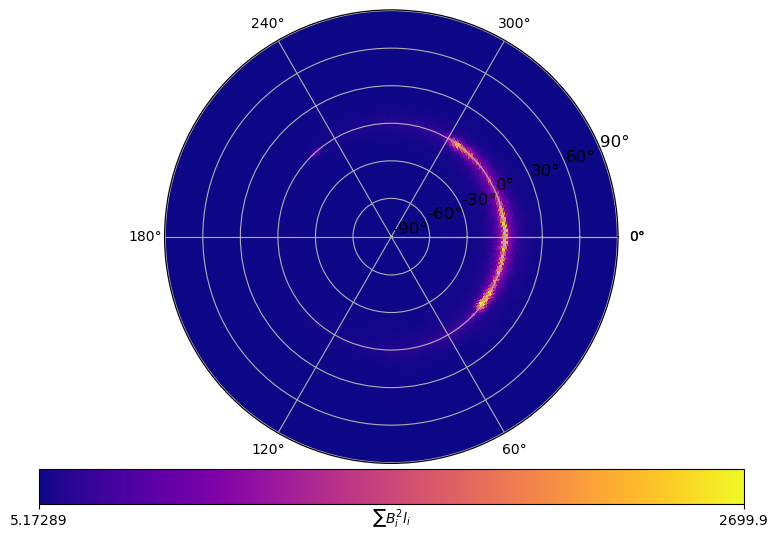

In [79]:
pixel_indices = hp.ang2pix(nside,theta,phi,lonlat=True)
npix = hp.nside2npix(nside)
i_pix = np.arange(npix)
factor=hp.ma(np.arange(hp.nside2npix(nside), dtype=np.double))
for i in range(npix):
    factor[i] = np.linalg.norm(result[i])   ## for probability calculating today


projview(
    factor,
    coord=["G"],
    hold=False,
    graticule=True,
    graticule_labels=True,
    flip="astro",
    projection_type="polar",
    unit="$\sum$$B_{i}^{2}l_{i}$",
    cb_orientation="horizontal",
    xsize=300,
    fontsize={"xtick_label": 10,"cbar_label": 10,"cbar_tick_label": 10},
    override_plot_properties={
        "cbar_shrink": 0.5,
        "cbar_pad": 0.01,
        "cbar_label_pad": -15,
        "figure_width": 15,
        "figure_size_ratio": 0.4,
    },
    cmap='plasma'
       
)

#plt.savefig("BperpProjectview_mask.png",bbox_inches='tight')